In [48]:
import tensorflow as tf
tf.debugging.set_log_device_placement(False)
from keras.models import Model
import matplotlib.pyplot as plt
import os
import numpy as np
import keras
import sklearn
import sklearn.model_selection
from sklearn.utils import shuffle 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow_model_optimization.python.core.keras.compat import keras

In [49]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


In [50]:
def get_gzipped_model_size(file):
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

# Chargement des données

In [51]:
# Le dossier principal qui contient les donn�es
mainDataPath = "Database/archive/leapGestRecog/"

# Le nom du fichier du mod�le � sauvegarder
modelsPath = "model/model.h5"

training_batch_size = 18000  
validation_batch_size = 6000  

# Configuration des  images 
image_scale = 120 
image_channels = 1  
images_color_mode = "grayscale" 
image_shape = (image_scale, image_scale, image_channels) 

# Configuration des param�tres d'entrainement
fit_batch_size = 60 # le nombre d'images entrain�es ensemble: un batch
fit_epochs = 5 # Le nombre d'�poques 

In [52]:
def load_and_preprocess_image(filename, image_channels):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=image_channels)
    return image

# Initialize lists to store images and labels
x_data = []
y_data = []

# Dictionaries for label encoding and decoding
lookup = {}
reverselookup = {}
label_count = 0

# Create label mappings based on subfolders
for folder_name in os.listdir(mainDataPath + '00/'):
    if not folder_name.startswith('.'):
        lookup[folder_name] = label_count
        reverselookup[label_count] = folder_name
        label_count += 1

# Load images and labels
for i in range(10):  # Assumes folders named '00' to '09'
    folder_path = f'{mainDataPath}0{i}/'
    for gesture_folder in os.listdir(folder_path):
        if not gesture_folder.startswith('.'):
            for image_file in os.listdir(f'{folder_path}{gesture_folder}/'):
                # Load and resize each image
                img_path = f'{folder_path}{gesture_folder}/{image_file}'
                #img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = load_and_preprocess_image(img_path, image_channels)
                
                # Check if image is loaded successfully
                if img is None:
                    print(f"Warning: Image {img_path} could not be loaded.")
                    continue

                # Resize and add to dataset
                #img = cv2.resize(img, (image_scale, image_scale))
                img = tf.image.resize(img, (image_scale, image_scale))
                x_data.append(img)
                y_data.append(lookup[gesture_folder])


# Convert lists to numpy arrays and normalize
x_data = np.array(x_data, dtype='float32').reshape(-1, image_scale, image_scale, 1) / 255.0
y_data = np.array(y_data)

y_data = to_categorical(y_data, num_classes=len(lookup))

# Shuffle the dataset
x_data, y_data = shuffle(x_data, y_data, random_state=42)

# Split into training and validation sets (80% train, 20% validation)
x_train, x_vt, y_train, y_vt = sklearn.model_selection.train_test_split(x_data, y_data, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = sklearn.model_selection.train_test_split(x_vt, y_vt, test_size=0.3, random_state=42)

print("Dataset loaded.")
print(f"Total images: {len(x_data)}")
print(f"Image shape: {x_data[0].shape}")
print(f"Number of classes: {len(lookup)}")

print("Label mappings:", lookup)

print(f"Training set shape: {x_train.shape}, {y_train.shape}")
print(f"Validation set shape: {x_val.shape}, {y_val.shape}")
print(f"Validation set shape: {x_test.shape}, {y_test.shape}")

Dataset loaded.
Total images: 20000
Image shape: (120, 120, 1)
Number of classes: 10
Label mappings: {'05_thumb': 0, '08_palm_moved': 1, '02_l': 2, '01_palm': 3, '07_ok': 4, '10_down': 5, '06_index': 6, '09_c': 7, '03_fist': 8, '04_fist_moved': 9}
Training set shape: (14000, 120, 120, 1), (14000, 10)
Validation set shape: (4200, 120, 120, 1), (4200, 10)
Validation set shape: (1800, 120, 120, 1), (1800, 10)


# Entrainement du model

In [53]:
input_layer = keras.layers.Input(shape=image_shape)


# Partie feature extraction (ou cascade de couches d'extraction des caract�ristiques)
def feature_extraction(input):
  
    
    x = keras.layers.Conv2D(32, (3, 3), padding='same')(input) 
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(64, (3, 3), padding='same')(x) 
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(128, (3, 3), padding='same')(x) 
    x = keras.layers.Activation("relu")(x)
    encoded = keras.layers.MaxPooling2D((2, 2))(x)
    return encoded


# Partie compl�tement connect�e (Fully Connected Layer)
def fully_connected(encoded):
    x = keras.layers.Flatten(input_shape=image_shape)(encoded)
    x = keras.layers.Dense(128)(x)
    x = keras.layers.Activation("relu")(x)
    x= keras.layers.Dropout(0.5)(x)

    x = keras.layers.Dense(10)(x)
    sortie = keras.layers.Activation('softmax')(x)
    return sortie


# D�claration du mod�le:
# La sortie de l'extracteur des features sert comme entr�e � la couche compl�tement connect�e
model = keras.Model(input_layer, fully_connected(feature_extraction(input_layer)))

# Affichage des param�tres du mod�le
# Cette commande affiche un tableau avec les d�tails du mod�le 
# (nombre de couches et de param�tre ...)
model.summary()
# Compilation du mod�le :
# On d�finit la fonction de perte (exemple :loss='binary_crossentropy' ou loss='mse')
# L'optimisateur utilis� avec ses param�tres (Exemple : optimizer=adam(learning_rate=0.001) )
# La valeur � afficher durant l'entrainement, metrics=['accuracy'] 
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 32)      320       
                                                                 
 activation (Activation)     (None, 120, 120, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 60, 60, 64)        0         
                                                             

In [54]:
modelcheckpoint = keras.callbacks.ModelCheckpoint(filepath=modelsPath,
                                  monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')


classifier = model.fit(x_train, y_train,
                       epochs=fit_epochs,
                       batch_size=fit_batch_size, 
                       validation_data=(x_val, y_val),
                       verbose=1, 
                       callbacks=[modelcheckpoint],
                       shuffle=True)

Epoch 1/5
234/234 [==============================] - ETA: 0s - loss: 2.2355 - accuracy: 0.7562
Epoch 1: val_accuracy improved from -inf to 0.97738, saving model to model/model.h5
234/234 [==============================] - 16s 62ms/step - loss: 2.2355 - accuracy: 0.7562 - val_loss: 0.9724 - val_accuracy: 0.9774
Epoch 2/5
  2/234 [..............................] - ETA: 11s - loss: 9.2957 - accuracy: 0.8083 

/Users/mamoudousdiani/miniconda3/envs/tf_clone/lib/python3.9/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


233/234 [============================>.] - ETA: 0s - loss: 8.0962 - accuracy: 0.9305
Epoch 2: val_accuracy improved from 0.97738 to 0.99095, saving model to model/model.h5
234/234 [==============================] - 13s 56ms/step - loss: 8.0846 - accuracy: 0.9306 - val_loss: 2.1099 - val_accuracy: 0.9910
Epoch 3/5
233/234 [============================>.] - ETA: 0s - loss: 14.9710 - accuracy: 0.9600
Epoch 3: val_accuracy improved from 0.99095 to 0.99595, saving model to model/model.h5
234/234 [==============================] - 13s 54ms/step - loss: 14.9496 - accuracy: 0.9601 - val_loss: 2.5479 - val_accuracy: 0.9960
Epoch 4/5
234/234 [==============================] - ETA: 0s - loss: 30.1260 - accuracy: 0.9708
Epoch 4: val_accuracy improved from 0.99595 to 0.99714, saving model to model/model.h5
234/234 [==============================] - 13s 55ms/step - loss: 30.1260 - accuracy: 0.9708 - val_loss: 3.2013 - val_accuracy: 0.9971
Epoch 5/5
233/234 [============================>.] - ETA: 0s 

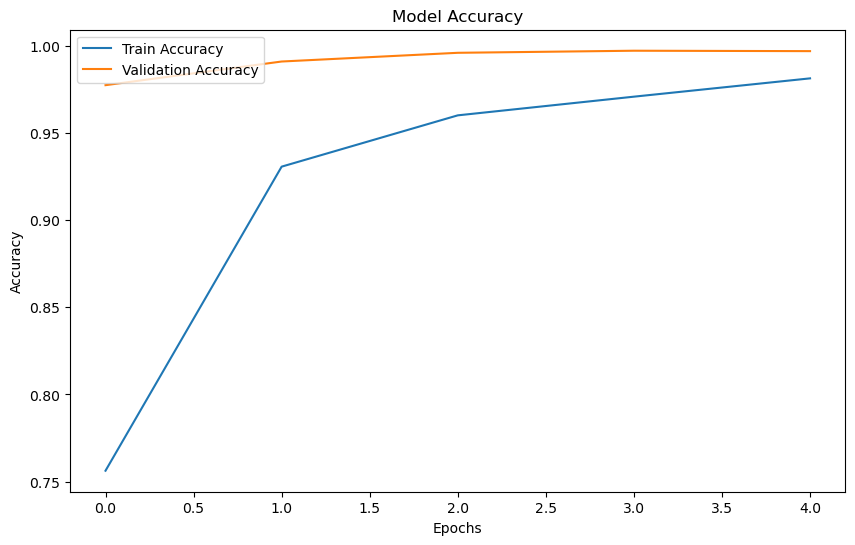

In [55]:
# Plot the training & validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(classifier.history['accuracy'], label='Train Accuracy')
plt.plot(classifier.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show() 


# Test du model

In [56]:
# Evaluate the model on validation data
test_loss, base_test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Validation Accuracy: {base_test_acc * 100:.2f}%')



57/57 - 1s - loss: 10.2645 - accuracy: 0.9978 - 1s/epoch - 20ms/step
Validation Accuracy: 99.78%


## Exemple de prediction d'une image randum

1/1 [==============================] - 0s 265ms/step


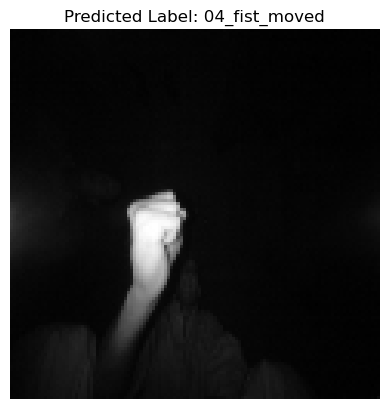

In [57]:
import random
random_idx = random.randint(0, len(x_val) - 1)
img = x_val[random_idx].reshape(1, image_scale, image_scale, 1)

prediction = model.predict(img)
predicted_class = np.argmax(prediction)

predicted_label = reverselookup[predicted_class]

plt.imshow(x_val[random_idx].reshape(image_scale, image_scale), cmap='gray')
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()

# Pruning du model

In [59]:
from tensorflow.keras.models import load_model
import tensorflow_model_optimization as tfmot


model_path = "model/model.h5"
model = keras.models.load_model(model_path)
print("*********** Model summary*********")
print(model.summary())



*********** Model summary*********
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 32)      320       
                                                                 
 activation (Activation)     (None, 120, 120, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 60, 60, 64)        0         
                          

In [60]:
batch_size=60
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
num_images = x_train.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * fit_epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 1)]     0         
                                                                 
 prune_low_magnitude_conv2d  (None, 120, 120, 32)      610       
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_activa  (None, 120, 120, 32)      1         
 tion (PruneLowMagnitude)                                        
                                                                 
 prune_low_magnitude_max_po  (None, 60, 60, 32)        1         
 oling2d (PruneLowMagnitude                                      
 )                                                               
                                                                 
 prune_low_magnitude_conv2d  (None, 60, 60, 64)        36930 

In [61]:
import tempfile
log_dire=tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=log_dire),
]


classifier =model_for_pruning.fit(x_train, y_train,
                  batch_size=512, epochs=3, validation_data=(x_val, y_val),
                  callbacks=callbacks)

keras.models.save_model(model_for_pruning, "model/model_pruned.h5", include_optimizer=False)


Epoch 1/3
 6/28 [=====>........................] - ETA: 12s - loss: 73.2809 - accuracy: 0.9521WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1684s vs `on_train_batch_end` time: 0.3766s). Check your callbacks.


28/28 [==============================] - 18s 547ms/step - loss: 68.5691 - accuracy: 0.9634 - val_loss: 6.2788 - val_accuracy: 0.9969
Epoch 2/3
28/28 [==============================] - 14s 519ms/step - loss: 55.0761 - accuracy: 0.9744 - val_loss: 4.9358 - val_accuracy: 0.9981
Epoch 3/3
28/28 [==============================] - 14s 507ms/step - loss: 49.0170 - accuracy: 0.9786 - val_loss: 2.0434 - val_accuracy: 0.9990


/var/folders/x1/s72xqs4s1n73j68r6wm3y_6w0000gn/T/ipykernel_1083/1423643588.py:14: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model_for_pruning, "model/model_pruned.h5", include_optimizer=False)


In [62]:
_, model_pruned_accuracy = model_for_pruning.evaluate(x_test, y_test, verbose=2)

print('Baseline test accuracy:', base_test_acc * 100)
print('Pruned test accuracy:', model_pruned_accuracy*100)

57/57 - 1s - loss: 3.0557 - accuracy: 0.9989 - 542ms/epoch - 10ms/step
Baseline test accuracy: 99.77777600288391
Pruned test accuracy: 99.8888909816742


### Suppression de toutes les variables tensorflow non necessaire 

In [63]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

keras.models.save_model(model_for_export, "model/model_pruned_export.h5", include_optimizer=False)




/var/folders/x1/s72xqs4s1n73j68r6wm3y_6w0000gn/T/ipykernel_1083/41469463.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model_for_export, "model/model_pruned_export.h5", include_optimizer=False)


# Creation d'un modele pour TFLite

In [64]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()


with open("model/model_pruned_TFLite.tflite", 'wb') as f:
  f.write(pruned_tflite_model)


INFO:tensorflow:Assets written to: /var/folders/x1/s72xqs4s1n73j68r6wm3y_6w0000gn/T/tmp8ke1ikif/assets


INFO:tensorflow:Assets written to: /var/folders/x1/s72xqs4s1n73j68r6wm3y_6w0000gn/T/tmp8ke1ikif/assets
W0000 00:00:1736318562.539723    9387 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1736318562.539901    9387 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-01-08 01:42:42.541328: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/x1/s72xqs4s1n73j68r6wm3y_6w0000gn/T/tmp8ke1ikif
2025-01-08 01:42:42.542276: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-01-08 01:42:42.542283: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/x1/s72xqs4s1n73j68r6wm3y_6w0000gn/T/tmp8ke1ikif
2025-01-08 01:42:42.549726: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-01-08 01:42:42.574187: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /var/folders/x1/s72xqs4s

# Quantisation

In [65]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

with open("model/model_quantized_and_pruned_tflite.tflite", 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

INFO:tensorflow:Assets written to: /var/folders/x1/s72xqs4s1n73j68r6wm3y_6w0000gn/T/tmp25hi08be/assets


INFO:tensorflow:Assets written to: /var/folders/x1/s72xqs4s1n73j68r6wm3y_6w0000gn/T/tmp25hi08be/assets
W0000 00:00:1736318563.298125    9387 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1736318563.298136    9387 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-01-08 01:42:43.298239: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/x1/s72xqs4s1n73j68r6wm3y_6w0000gn/T/tmp25hi08be
2025-01-08 01:42:43.299060: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-01-08 01:42:43.299066: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/x1/s72xqs4s1n73j68r6wm3y_6w0000gn/T/tmp25hi08be
2025-01-08 01:42:43.305230: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-01-08 01:42:43.324418: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /var/folders/x1/s72xqs4s

### Quantization 2

In [66]:
model = keras.models.load_model('model/model_pruned_export.h5')
quantize_model = tfmot.quantization.keras.quantize_model
quantized_model = quantize_model(model)

# Sauvegarde
quantized_model.save('model/model_pruned_and_quantized.h5')
_, model_pruned_quantized_accuracy = model_for_pruning.evaluate(x_test, y_test, verbose=2)


/Users/mamoudousdiani/miniconda3/envs/tf_clone/lib/python3.9/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 - 1s - loss: 3.0557 - accuracy: 0.9989 - 727ms/epoch - 13ms/step


# Test

## Test du poids

In [69]:
print("taille du model de base zippé : %.2f Mo" % (get_gzipped_model_size("model/model.h5")/(1024 ** 2)))
print("taille du model pruné zippé : %.2f Mo" % (get_gzipped_model_size("model/model_pruned.h5")/(1024 ** 2)))
print("taille du model pruné et converti TFLite zippé : %.2f Mo" % (get_gzipped_model_size("model/model_pruned_TFLite.tflite")/(1024 ** 2)))
print("taille du model pruné, quantisé et converti TFLite zippé : %.2f Mo" % (get_gzipped_model_size("model/model_quantized_and_pruned_tflite.tflite")/(1024 ** 2)))
print("taille du model pruné, quantisé zippé : %.2f Mo" % (get_gzipped_model_size("model/model_pruned_and_quantized.h5")/(1024 ** 2)))

taille du model de base zippé : 36.22 Mo
taille du model pruné zippé : 13.50 Mo
taille du model pruné et converti TFLite zippé : 13.37 Mo
taille du model pruné, quantisé et converti TFLite zippé : 2.57 Mo
taille du model pruné, quantisé zippé : 13.48 Mo


In [71]:

import os
print(f"taille du model de base : {os.path.getsize('model/model.h5') / (1024 ** 2):.2f} Mo" )
print(f"taille du model pruné : {os.path.getsize('model/model_pruned.h5') / (1024 ** 2):.2f} Mo" )
print(f"taille du model pruné et converti TFLite : {os.path.getsize('model/model_pruned_TFLite.tflite') / (1024 ** 2):.2f} Mo" )
print(f"taille du model pruné, quantisé et converti TFLite : {os.path.getsize('model/model_quantized_and_pruned_tflite.tflite') / (1024 ** 2):.2f} Mo" )
print(f"taille du model pruné, quantisé : {os.path.getsize('model/model_pruned_and_quantized.h5') / (1024 ** 2):.2f} Mo" )

taille du model de base : 43.33 Mo
taille du model pruné : 28.91 Mo
taille du model pruné et converti TFLite : 14.43 Mo
taille du model pruné, quantisé et converti TFLite : 3.61 Mo
taille du model pruné, quantisé : 14.49 Mo


## Test de precision

In [72]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  print(input_index)

  # Run predictions on ever y image in the "test" dataset.
  prediction_digits = []
  for i, x in enumerate(x_test):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    x = np.expand_dims(x, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, x)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  y_test_indices = np.argmax(y_test, axis=1)
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == y_test_indices).mean()
  return accuracy

In [73]:
interpreter = tf.lite.Interpreter(model_content=pruned_tflite_model)

interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)


0
Evaluated on 0 results so far.
Evaluated on 1000 results so far.




In [74]:
interpreter.get_input_details()

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([  1, 120, 120,   1], dtype=int32),
  'shape_signature': array([ -1, 120, 120,   1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [76]:
interpreter = tf.lite.Interpreter(model_content=pruned_tflite_model)

interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)


interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model)
interpreter.allocate_tensors()

test_accuracy_1 = evaluate_model(interpreter)

print('model de base test accuracy:', base_test_acc * 100)
print('model pruné test accuracy:', model_pruned_accuracy*100)
print('model pruné TF test accuracy:', test_accuracy*100)
print('model pruné and quantisé TFLite test accuracy:', test_accuracy_1*100)
print('model pruné et quantisé', model_pruned_quantized_accuracy*100)

#model_pruned_and_quantized


0
Evaluated on 0 results so far.
Evaluated on 1000 results so far.


0
Evaluated on 0 results so far.
Evaluated on 1000 results so far.


model de base test accuracy: 99.77777600288391
model pruné test accuracy: 99.8888909816742
model pruné TF test accuracy: 99.16666666666667
model pruné and quantisé TFLite test accuracy: 99.16666666666667
model pruné et quantisé 99.8888909816742


# Convertion en C

### conversion avec xxd
xxd est un outil de conversion qui sert à convertir des fichiers binaires ( modèles .h5, .tflite) en une représentation hexadécimale ou en tableau C, qui peut ensuite être directement intégré dans un programme écrit en C.

In [3]:
!xxd -i model/model_quantized_and_pruned_tflite.tflite > model/model_quantized_tflite.c

In [4]:
import os
print(f"taille du model de base : {os.path.getsize('model/model_quantized_tflite.c') / (1024 ** 2):.2f} Mo" )


taille du model de base : 22.28 Mo


### conversion avec keras2c
keras2c Keras2C est un outil conçu pour convertir un modèle Keras en code C statique. Il permet de déployer des modèles d'apprentissage automatique dans des environnements où les ressources sont limitées, tels que les systèmes embarqués ou les microcontrôleurs.
https://github.com/PlasmaControl/keras2c.git
https://indico.cern.ch/event/737461/contributions/3729531/attachments/2120600/3570905/keras2c_slides.pdf